In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load dataxq
pd_data = pd.read_csv('../../datasets/boston.csv')

In [5]:

X = pd_data.drop(columns=['CRIM','AGE','NOX','B','MEDV','TAX',"INDUS","CHAS","RAD","ZN"])
y = pd_data['MEDV'] 

print(X.columns)



X.columns = [
    # 'Crime Rate',
    # '% Residential in Area', 
    # '% Business in Area', 
    # 'River', 
    # 'Air Pollution',
    '#Rooms',
    # '% Pre-1940 Units',
    'Dist to Biz', 
    # 'Highway Accessibility',
    # 'Property Tax Rate',
    'Stu-Tea Ratio',
    '% Lower Income',
]

Index(['RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 训练测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test) 
r2_socre_ = r2_score(y_test, preds)
print(r2_socre_)
rmse_score = np.sqrt(np.mean((y_test - preds) ** 2))
print(rmse_score)

0.844940872122678
3.3721020833872033


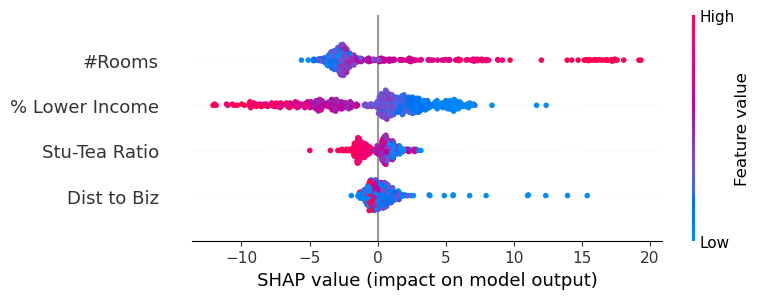

In [7]:
import shap
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X)

In [14]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)
ood_cluster = 1
ood_indices = np.where(cluster_labels == ood_cluster)[0]
in_dist_indices = np.where(cluster_labels != ood_cluster)[0]
# 3. Split in-distribution data into train/test
X_in, y_in = X.iloc[in_dist_indices], y.iloc[in_dist_indices]
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X_in, y_in, test_size=0.2, random_state=42)

# 4. Train model on in-distribution data
rf_in = RandomForestRegressor(n_estimators=100, random_state=42)
rf_in.fit(X_train_in, y_train_in)

in_preds = rf.predict(X_test_in)
in_r2 = r2_score(y_test_in, in_preds)
in_rmse = np.sqrt(np.mean((y_test_in - in_preds)**2))

# 6. Evaluate on OOD cluster
X_ood, y_ood = X.iloc[ood_indices], y.iloc[ood_indices]
ood_preds = rf_in.predict(X_ood)
ood_r2 = r2_score(y_ood, ood_preds)
ood_rmse = np.sqrt(np.mean((y_ood - ood_preds)**2))

print(f"In-distribution R2: {in_r2:.3f}, RMSE: {in_rmse:.3f}")
print(f"OOD R2: {ood_r2:.3f}, RMSE: {ood_rmse:.3f}")

In-distribution R2: 0.858, RMSE: 1.826
OOD R2: -0.323, RMSE: 10.109


In [15]:
X_train.columns

Index(['#Rooms', 'Dist to Biz', 'Stu-Tea Ratio', '% Lower Income'], dtype='object')

In [16]:
print(len(in_dist_indices),len(ood_indices))

257 249


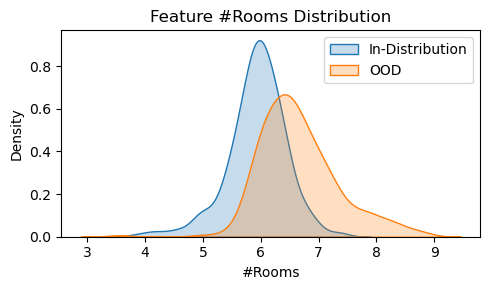

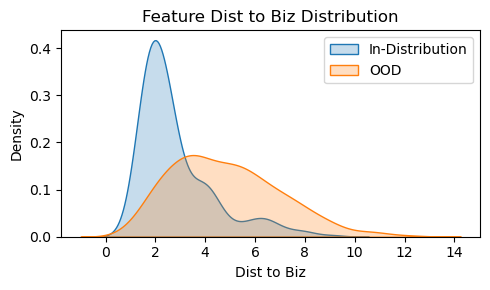

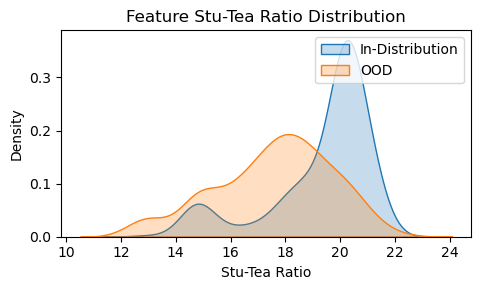

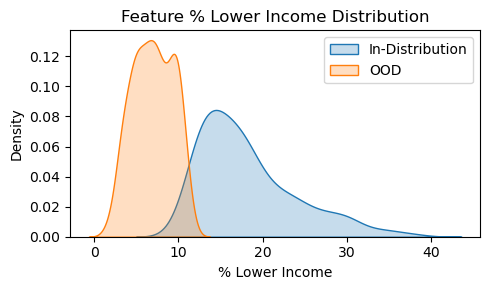

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(X.shape[1]):
    plt.figure(figsize=(5, 3))
    sns.kdeplot(X.iloc[in_dist_indices, i], label='In-Distribution', fill=True)
    sns.kdeplot(X.iloc[ood_indices, i], label='OOD', fill=True)
    plt.title(f'Feature {X_train.columns[i]} Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

for OOD 
% Lower income is from 0 - 10 (5)
for In Distribution
% Lower income is from 10 - 40 (15)

In [11]:
train_preds = rf.predict(X_train_in)

min_index = np.argmin(train_preds)  # min val index
max_index = np.argmax(train_preds)  # max val index
mean_value = np.mean(train_preds)   # mean val 

closest_mean_index = np.argmin(np.abs(train_preds - mean_value))  # 


# Define function f(x) using rf.predict.
def f(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])

print("predcition",train_preds[[min_index, closest_mean_index, max_index]])
print("labels",y_train_in.iloc[[min_index, closest_mean_index, max_index]].values)


predcition [12.637 26.421 47.988]
labels [10.2 28.1 50. ]


In [12]:
X.columns

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')

In [13]:
def f_in(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf_in.predict(x_df)[0])

In [17]:

import sys
sys.path.append("../../")
from utils import explain_prediction
from Approach_ import RelatabilitySolver  # Import lver
from search_strategies import AStarStrategy, GreedyBestFirstStrategy
import time
from utils import explain_prediction

prototypes = X_train_in.iloc[[min_index, closest_mean_index, max_index]].values
prototype_labels = y_train_in.iloc[[min_index, closest_mean_index, max_index]].values
# Initialize the RelatabilitySolver
solver = RelatabilitySolver(
    f=f_in,
    prototypes=prototypes,
    prototype_labels=prototype_labels,
    partitions=4,  # number of grid points between prototype and target
    max_steps=5    # maximum steps in the path
)

index = 3
# Example: Explain a prediction for a test house
test_house = X_test_in.iloc[index].values  # Take first house from test set as example
print("=== Target House ===")
print(f"Actual price: ${y_test_in.iloc[index]:.2f}")
print(f"Predicted price: ${f(test_house):.2f}")
print("\nGenerating explanation...")


preds_train_in = rf.predict(X_train_in) 
# Find and show explanation
explain_prediction(solver, X_train_in, y_train_in, preds_train_in,test_house, threshold=0.1)


=== Target House ===
Actual price: $19.40
Predicted price: $20.50

Generating explanation...
prototype [ 6.375  32.3     3.9454 18.6     9.38  ] label: 28.1 prediction: 25.49899999999997

=== Explanation Path Found ===

Starting Point (Prototype):
Predicted Price: $25.50

Step 1:
------------------------------
Price: $23.45 (-2.05)
Changes made:
  #Rooms: ↓ 0.34

Most Similar Case Found:
  Dataset Index: 45
  Actual Label: $23.40
  Predicted Label: $22.15

Step 2:
------------------------------
Price: $22.84 (-0.61)
Changes made:
  Dist to Biz: ↑ 0.67

Most Similar Case Found:
  Dataset Index: 45
  Actual Label: $23.40
  Predicted Label: $22.15

Step 3:
------------------------------
Price: $22.55 (-0.29)
Changes made:
  Dist to Biz: ↑ 2.02

Most Similar Case Found:
  Dataset Index: 66
  Actual Label: $24.80
  Predicted Label: $24.52

=== Final Result ===
Total Steps: 3
Path Error: 0.3690
Total Price Change: $-2.95


In [28]:
ood_preds

array([22.585, 20.64 , 19.304, 20.967, 20.936, 21.037, 20.838, 20.195,
       18.627, 19.673, 22.794, 19.433, 19.691, 18.57 , 19.123, 21.14 ,
       22.204, 24.2  , 19.204, 20.738, 19.627, 19.006, 20.941, 21.395,
       19.12 , 19.032, 29.837, 25.68 , 22.47 , 21.718, 21.47 , 13.534,
       17.312, 17.825, 22.308, 23.511, 26.535, 21.05 , 23.322, 23.692,
       20.597, 22.201, 19.368, 15.244, 15.226, 14.694, 16.063, 14.748,
       13.901, 19.898, 13.545, 19.986, 21.275, 22.075, 19.549, 19.437,
       19.038, 14.339, 19.944, 14.017, 20.324, 18.446, 13.534, 16.994,
       16.994, 16.577, 19.41 , 16.674, 16.577, 16.726, 16.718, 18.739,
       17.361, 17.374, 16.764, 19.371, 22.035, 16.759, 31.425, 21.255,
       25.149, 24.713, 42.542, 43.979, 44.13 , 21.096, 22.786, 44.569,
       20.933, 21.285, 22.623, 21.223, 21.022, 19.693, 25.59 , 43.852,
       31.089, 25.755, 19.283, 20.193, 21.321, 20.148, 25.365, 21.186,
       22.694, 28.036, 21.412, 25.34 , 44.093, 43.709, 30.254, 21.076,
      

In [31]:
len(y_ood.values)

252

In [39]:
(abs(y_ood - ood_preds)).mean()

4.987063492063493

In [45]:
np.where((abs(y_ood - ood_preds)) > 10)

(array([135, 136, 139, 140, 141, 142, 143, 146, 148, 151, 152, 172, 178,
        186, 187, 190, 200, 204, 205, 218, 221, 222]),)

In [40]:
(abs(y_train_in - preds_train_in)).mean()

0.9319261083743838

In [41]:
(abs(y_test_in - in_preds)).mean()

0.9427254901960752

In [46]:
index = 135

# Example: Explain a prediction for a test house
test_house_ood = X_ood.iloc[index].values  # Take first house from test set as example
print("=== OOD Target House ===")
print(f"Actual price: ${y_ood.iloc[index]:.2f}")
print(f"Predicted price: ${f(test_house_ood):.2f}")
print("\nGenerating explanation...")
# Find and show explanation
explain_prediction(solver, X_ood, y_ood, ood_preds,test_house_ood, threshold=0.1)

=== OOD Target House ===
Actual price: $21.90
Predicted price: $30.28

Generating explanation...
prototype [ 8.297  67.      2.4216 13.      7.44  ] label: 50.0 prediction: 48.29700000000002

=== Explanation Path Found ===

Starting Point (Prototype):
Predicted Price: $48.30

Step 1:
------------------------------
Price: $44.43 (-3.87)
Changes made:
  % Pre-1940 Units: ↑ 7.95

Most Similar Case Found:
  Dataset Index: 110
  Actual Label: $31.60
  Predicted Label: $30.25

Step 2:
------------------------------
Price: $42.44 (-1.99)
Changes made:
  Stu-Tea Ratio: ↑ 7.20

Most Similar Case Found:
  Dataset Index: 110
  Actual Label: $31.60
  Predicted Label: $30.25

Step 3:
------------------------------
Price: $42.68 (+0.23)
Changes made:
  % Pre-1940 Units: ↑ 3.98

Most Similar Case Found:
  Dataset Index: 110
  Actual Label: $31.60
  Predicted Label: $30.25

Step 4:
------------------------------
Price: $42.68 (+0.00)
Changes made:
  % Pre-1940 Units: ↑ 3.97

Most Similar Case Found:
 